# DBQA on Quantinuum

This notebook is an attempt to fully implement DBQA on pytket using native gates.
For VQE training, see notebook [`quantinuum_native_gate_vqe.ipynb`](https://github.com/qiboteam/boostvqe/blob/c55d0df0bcf5abc39a50d9599060335f8b11739c/notebooks/quantinuum_native_gate_vqe.ipynb).

In the examples, we will be using the XXZ model given by:
$$
H_0 = \sum _{k=0}^L \left( X_{k} X_{k + 1} + Y_{k} Y_{k + 1} + \delta Z_{k}Z_{k + 1} \right)
$$

# 1. Imports and help functions

In [1]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
import pytket.qasm
from datetime import datetime
import numpy as np
import scipy
import matplotlib.pyplot as plt
from qibo import hamiltonians
from scipy.optimize import minimize
from qibo.symbols import X, Y, Z
from copy import deepcopy

In [2]:
# set plot rcparams
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.labelspacing'] = .3
plt.rcParams['legend.columnspacing']= .3
plt.rcParams['legend.handletextpad']= .1
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams["figure.figsize"] = [5, 3.50]
plt.rcParams["figure.autolayout"] = True

In [3]:
# XXZ model matrix
def construct_XXZ(nqubits, delta=0.5, boundary='closed'):
    if boundary == 'periodic' or boundary == 'closed':
        return hamiltonians.XXZ(nqubits, delta).matrix
    elif boundary == 'open':
        H_sym = sum([X(i)*X(i+1)+ Y(i)*Y(i+1) + delta* Z(i)*Z(i+1) for i in range(nqubits-1)])
        return hamiltonians.SymbolicHamiltonian(H_sym).matrix

In [4]:
# XXZ model circuit (native gates)
def XX_interaction(qc, q0, q1, t):
    qc.H(q0), qc.H(q1)
    qc.ZZPhase(t*2/np.pi, q0, q1)
    qc.H(q0), qc.H(q1)

def YY_interaction(qc, q0, q1, t):
    qc.Sdg(q0), qc.Sdg(q1)
    XX_interaction(qc, q0, q1, t)
    qc.S(q0), qc.S(q1)

def ZZ_interaction(qc, q0, q1, t):
    qc.ZZPhase(t*2/np.pi, q0, q1)
    
def XXZ_decomposition(nqubits, t, delta=0.5, qc=None, layer=2, boundary='closed'):
    # This function generates the circuit that simulates e^{itH}
    # where H is the XXZ model
    # nqubits must be equal or greater than 2
    def generate_adjacent_pairs(n):
        if n < 2:
            raise ValueError("Input nqubits must be equal to or larger than 2.")
        even_starting_pairs = [[s, s+1] for s in range(0, n-1, 2)]
        odd_starting_pairs = [[s, s+1] for s in range(1,n-1, 2)]
        if boundary == 'periodic' or boundary == 'closed':
            # print('periodic case')
            if nqubits % 2 == 0:
                # even number of qubits add to odd pairs
                odd_starting_pairs.append([0, nqubits-1])
            else:
                even_starting_pairs.append([0, nqubits-1])
                # note that odd number of qubits result in degenerate ground states
        return even_starting_pairs, odd_starting_pairs
    even_starting_pairs, odd_starting_pairs = generate_adjacent_pairs(nqubits)
    if qc is None:
        qc = Circuit(nqubits) 
    if layer == 2:
        for q0, q1 in even_starting_pairs:
            XX_interaction(qc, q0, q1, t)
            YY_interaction(qc, q0, q1, t)
            ZZ_interaction(qc, q0, q1, t*delta)
        for q0, q1 in odd_starting_pairs:
            XX_interaction(qc, q0, q1, t)
            YY_interaction(qc, q0, q1, t)
            ZZ_interaction(qc, q0, q1, t*delta) 
    elif layer == 3:
        for q0, q1 in even_starting_pairs:
            XX_interaction(qc, q0, q1, t/2)
            YY_interaction(qc, q0, q1, t/2)
            ZZ_interaction(qc, q0, q1, t*delta/2)
        for q0, q1 in odd_starting_pairs:
            XX_interaction(qc, q0, q1, t)
            YY_interaction(qc, q0, q1, t)
            ZZ_interaction(qc, q0, q1, t*delta) 
        for q0, q1 in even_starting_pairs:
            XX_interaction(qc, q0, q1, t/2)
            YY_interaction(qc, q0, q1, t/2)
            ZZ_interaction(qc, q0, q1, t*delta/2)
    else:
        raise ValueError("Number of layers not supported, use either '2' or '3'.")
    return qc

In [5]:
def unitary_expectation(H, U=None, ket0=None):
    if ket0 is None:
        ket0 = np.zeros((H.shape[0],), dtype=complex)
        ket0[0] = 1.0
    if U is None:
        psi = ket0
    else:
        psi = U @ ket0
    return np.vdot(psi, H @ psi).real

# 2. Hamiltonian simulation

## 2.1 Simple check: XX to ZZ
$$
H\otimes H e^{it Z\otimes Z}H\otimes H = X\otimes X ?
$$

In [34]:
# obtain e^{itX\otimes X} unitary
# Define the Pauli-X matrix
import scipy.linalg


x = np.array([[0, 1],
              [1, 0]], dtype=complex)

# Compute the tensor product X ⊗ X
xx = np.kron(x, x)

# Define the parameter t
t = np.pi / 6  # You can choose any real value for t

# Compute the unitary matrix U = e^{i t X⊗X}
U1 = scipy.linalg.expm(1j * t * xx)


In [35]:
# define the tensor hadamard unitary
hadamard = 1/np.sqrt(2) * np.array([[1,1],
                             [1,-1]], dtype=complex)
z = np.array([[1, 0],
              [0, -1]], dtype=complex)
hh = np.kron(hadamard, hadamard)
zz = np.kron(z,z)
U2 = hh @ scipy.linalg.expm(1j * t * zz) @ hh

In [36]:
np.linalg.norm(U1-U2)

9.496780065728157e-16

### 2.1.1 Circuit implementation

From the above test, we see that theoretically, the decomposition is correct. Now we will build the pytket circuit for this decomposition.

According to the documentation: https://docs.quantinuum.com/h-series/trainings/getting_started/pytket_quantinuum/Quantinuum_arbitrary_angle_zz.html, the arbitrary angle ZZ gate in pytket is defined as
$$
RZZ(\alpha) = e^{-i\frac{\alpha}{2}Z\otimes Z}
$$

However, it is actually
$$
RZZ(\alpha) = e^{-i\frac{\alpha\pi}{2}Z\otimes Z}
$$

Text(0, 0.5, 'Error')

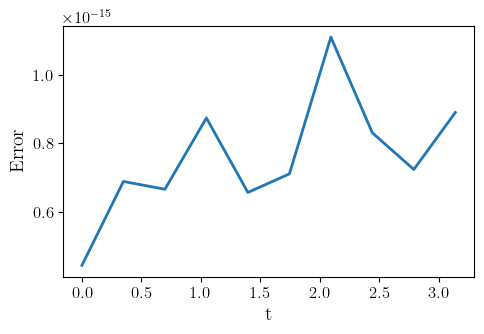

In [12]:
# compare our target circuit
diff = []
t_range = np.linspace(0, np.pi, 10)
for t in t_range:
    U1 = scipy.linalg.expm(1j * t * XX)
    circuit1 = Circuit(2)
    circuit1.H(0)
    circuit1.H(1)
    circuit1.ZZPhase(-t*2/np.pi, 0, 1)
    circuit1.H(0)
    circuit1.H(1)
    U2 = circuit1.get_unitary()
    diff.append(np.linalg.norm(U1-U2))
plt.plot(t_range, diff)
plt.xlabel('t')
plt.ylabel('Error')

## 2.2 XXZ model

Now we will use native gates to simulate the XXZ hamiltonian given by
$$
H_ = \sum _{k=0}^L \left( X_{k} X_{k + 1} + Y_{k} Y_{k + 1} + \delta Z_{k}Z_{k + 1} \right)
$$

Let's first consider the case with 2 qubit, since terms commute, the same strategy will apply to cases with more qubits.

Because the terms $X\otimes X$, $Y\otimes Y$, and $Z\otimes Z$ commute, we can write
$$
e^{it(XX+YY+ZZ)} = e^{itXX}e^{itYY}e^{itZZ}
$$

Then we have
$$
e^{itXX}=H\otimes H e^{itZZ}H\otimes H
$$
$$
e^{itYY}=(S\otimes S)(H\otimes H) e^{itZZ}(H\otimes H)(S^\dag\otimes S^\dag)
$$

Note that qibo.hamiltonians.XXZ for 2 qubits, there is an extra factor 2, that is QIBO_XXZ = 2 * XXZ.


Constructing an open boundary condition XXZ model (qibo XXZ uses periodic boundary condition)

### 2.2.1 Simple check: 2 qubit XXZ

In [9]:
t = np.pi/6
delta = 0.5
H = construct_XXZ(2, delta, boundary='open')
U1 = scipy.linalg.expm(1j*t*H)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[Qibo 0.2.13|INFO|2025-01-27 16:06:39]: Using qibojit (numba) backend on /CPU:0
[Qibo 0.2.13|WARNING|2025-01-27 16:06:39]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [10]:
t = np.pi/6
delta = 0.5
qc = Circuit(2)
# implement xx
qc.H(0), qc.H(1)
qc.ZZPhase(-t*2/np.pi, 0, 1)
qc.H(0), qc.H(1)

# implement yy
qc.Sdg(0), qc.Sdg(1)
qc.H(0), qc.H(1)
qc.ZZPhase(-t*2/np.pi, 0, 1)
qc.H(0), qc.H(1)
qc.S(0), qc.S(1)

# implement zz
qc.ZZPhase(-t*2/np.pi * delta, 0, 1)
U2 = qc.get_unitary()

In [11]:
# render_circuit_jupyter(qc)

In [12]:
np.linalg.norm(U1-U2)

1.486673200195252e-15

### 2.2.2 n-qubit XXZ

In this section, we check that the product formula converges to n qubit XXZ model evolution with Trotter-Suzuki formula.
To do this, we divide the interaction into odd and even sub-lattices.
i.e. [1,2], [3,4], [5,6] being `c_odd` and [2,3], [4,5] being `c_even`.
This way, we can run the non-interacting pairs simultaneously.


In the function definition, we consider 2 possible decomposition:
1. 2 layers (grouping by even and odd starting pairs): 
    $$
    e^{-itH} = e^{-itH_{\text{even}}}e^{-itH_{\text{odd}}}
    $$
2. 3 layers (sandwiching odd starting group with even while halfing time):
    $$
    e^{-itH} = e^{-it/2H_{\text{even}}}e^{-itH_{\text{odd}}}e^{-it/2H_{\text{even}}}
    $$

3 Layers will provide a better approximation for the hamiltonian simulation.

In [16]:
# ensure tensor product and qibo hamiltonian identical
nqubits = 8
delta = 0.5
H_qibo = hamiltonians.XXZ(nqubits, delta).matrix
H_tensor = construct_XXZ(nqubits, delta, 'periodic')
print(np.linalg.norm(H_qibo - H_tensor))

0.0


Let's first fix the time and evaluate the error as we increase the number of qubits.

In [17]:
test_qubits = [2,3,4,5,6,7,8,9,10]
t = np.pi/6
U1 = [scipy.linalg.expm(-1j*t*(construct_XXZ(n,delta))) for n in test_qubits]
U2 = [XXZ_decomposition(n, t, delta).get_unitary() for n in test_qubits]
U3 = [XXZ_decomposition(n, t, delta, layer=3).get_unitary() for n in test_qubits]
diff_12 = [np.linalg.norm(U1[i]-U2[i]) for i in range(len(test_qubits))]
diff_13 = [np.linalg.norm(U1[i]-U3[i]) for i in range(len(test_qubits))]

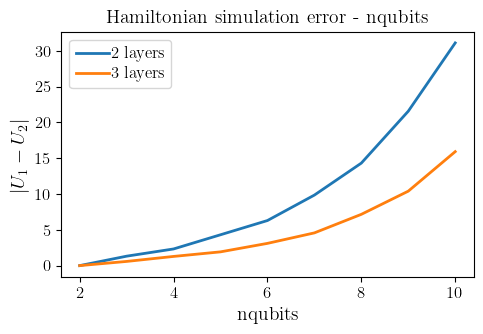

In [ ]:
plt.plot(test_qubits, diff_12, label='2 layers')
plt.plot(test_qubits, diff_13, label='3 layers')
plt.xlabel('nqubits')
plt.ylabel(r'$|U_1-U_2|$')
plt.title('Hamiltonian simulation error - nqubits')
plt.legend()

Now we fix nqubits and vary time.

In [19]:
nqubits = 8
test_t = np.linspace(0, 0.2, 30)
U1 = [scipy.linalg.expm(-1j*t*(construct_XXZ(nqubits,delta))) for t in test_t]
U2 = [XXZ_decomposition(nqubits, t, delta).get_unitary() for t in test_t]
U3 = [XXZ_decomposition(nqubits, t, delta, layer=3).get_unitary() for t in test_t]
diff_12 = [np.linalg.norm(U1[i]-U2[i]) for i in range(len(test_t))]
diff_13 = [np.linalg.norm(U1[i]-U3[i]) for i in range(len(test_t))]

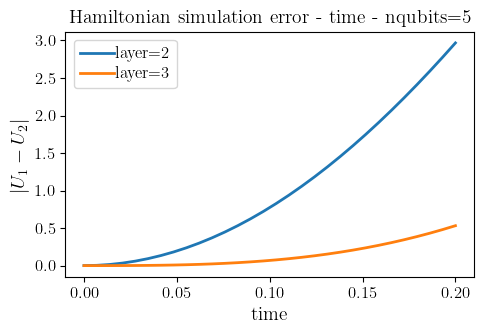

In [20]:
plt.plot(test_t, diff_12, label='layer=2')
plt.plot(test_t, diff_13, label='layer=3')
# plt.yscale('log')
plt.xlabel('time')
plt.ylabel(r'$|U_1-U_2|$')
plt.title('Hamiltonian simulation error - time - nqubits=5')
plt.legend()

Next, we see how trotterization reduces the error when we fix the time.

In [21]:
t = np.pi/20
nqubits = 6
n_trotter = 10
U1 = scipy.linalg.expm(-1j*t*(construct_XXZ(nqubits, delta)))

In [22]:
def trotter_circuit(nqubits, t, n_trotter, layer=2):
    qc = Circuit(nqubits)
    dt = t/n_trotter
    for n in range(n_trotter):
        qc = XXZ_decomposition(nqubits, dt, delta, qc, layer=layer)
    return qc

In [23]:
U2 = [trotter_circuit(nqubits, t, n).get_unitary() for n in range(1, n_trotter)]
U3 = [trotter_circuit(nqubits, t, n, layer=3).get_unitary() for n in range(1, n_trotter)]
diff_12 = [np.linalg.norm(U1-U2[i]) for i in range(n_trotter-1)]
diff_13 = [np.linalg.norm(U1-U3[i]) for i in range(n_trotter-1)]

Text(0.5, 1.0, 'Hamiltonian simulation error - trotter steps')

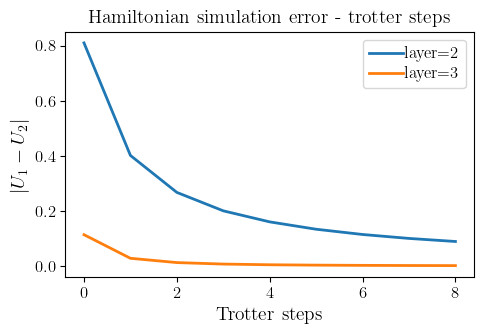

In [24]:
plt.plot(diff_12, label='layer=2')
plt.plot(diff_13, label='layer=3')
plt.legend()
plt.xlabel('Trotter steps')
plt.ylabel(r'$|U_1-U_2|$')
plt.title('Hamiltonian simulation error - trotter steps')

# 3. One step of DBQA

Now we have seen that using S, H, and ZZ gates, we are able to simulate the XXZ hamiltonian.

In the reduced group commutator notation, we denote $U$ as the VQE preconditioning unitary, 
the input Hamiltonian evolution $e^{-itH_0}$, and the diagonal evolution $ e^{itD}.

For one step of DBQA, 
$$
V_1 = e^{itD}U^\dagger e^{-itH_0}Ue^{-itD}
$$
and that
$$
A_1 = V_1^\dagger U^\dagger H_0 U V_1.
$$

With this we find
$$
\langle 0|A_1|0\rangle =\langle \psi_1|H_0|\psi\rangle
$$
where 
$$
|\psi\rangle = U* V_1|0\rangle.
$$

Therefore, our composed DBQA circuit should follow

$$
U_1 = U*V_1 = U_\theta e^{itD}U_\theta ^\dagger e^{-itH}U_\theta e^{-itD}
$$

In this example, we will use the closed boundary condition XXZ model with nqubits = 10.

## 3.1 Load VQE circuit

In [6]:
# Create Hamiltonian
nqubits = 10
H = hamiltonians.models.XXZ(nqubits=nqubits, delta=0.5, dense=False)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[Qibo 0.2.13|INFO|2025-02-07 10:42:10]: Using qibojit (numba) backend on /CPU:0


In [7]:
# Load the VQE circuit
optimizer = 'cobyla'
nqubits = nqubits
nlayer = 1
folder_path = f'results/circuit_qasm/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
vqe_circ_file = folder_path + 'vqe_circ.qasm'
vqe_circ = pytket.qasm.circuit_from_qasm(vqe_circ_file)
vqe_circ_inverse = vqe_circ.dagger()
U = vqe_circ.get_unitary()
U_dag = U.T.conjugate()
# check unitary
print('Check unitary (0):', np.linalg.norm(U@U_dag-np.eye(2**nqubits)))
# check expected energy
print('Expected energy:', unitary_expectation(H.matrix, U))

[Qibo 0.2.13|WARNING|2025-02-07 10:42:12]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


Check unitary (0): 3.924655838503855e-14
Expected energy: -13.686694061712272


$$
U1 = U_\theta e^{itD}U_\theta ^\dagger e^{-itH}U_\theta e^{-itD}
$$

### 3.1.1 Fixed D

In [8]:
# Find optimal starting s
# seed = 10
# np.random.seed(seed)
# coef = np.random.uniform(0.5, 1, nqubits)
coef = [1] * nqubits
D_circ_qibo = hamiltonians.SymbolicHamiltonian(sum([coef[x]*Z(x) for x in range(nqubits)]))
s_space = np.linspace(0, 0.5, 30)
expect_ls = []
for s in s_space:
    d = D_circ_qibo.circuit(s).unitary()
    d_dag = d.conjugate()
    h = scipy.linalg.expm(-1j*s*H.matrix)
    U1 = U @ d_dag @ U_dag @ h @ U @ d
    expect_ls.append(unitary_expectation(H.matrix, U1))

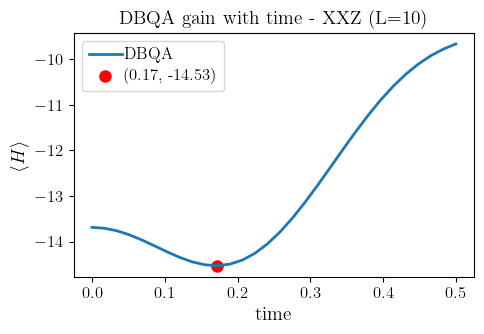

In [10]:
plt.plot(s_space, expect_ls, label='DBQA')
plt.title(f'DBQA gain with time - XXZ (L={nqubits})')
min_expect = min(expect_ls)
min_idx = expect_ls.index(min_expect)
s_min = s_space[min_idx]
plt.scatter(s_min, min_expect, color='red', label=f'{round(s_min,2), round(min_expect,2)}')
plt.xlabel('time')
plt.ylabel(r'$\langle H\rangle$')
plt.legend()

Now we will compose the circuit that executes the above unitary.
The first element is
$$
e^{-itD}
$$

Note that pytket $Rz(\alpha)=e^{-\frac{i}{2}\pi \alpha Z}$

In [6]:
def magnetic_field(coefs, t):
    # implments e^{-itD}
    nqubits = len(coefs)
    qc = Circuit(nqubits)
    
    for idx, coef in enumerate(coefs):
        theta = 2 * t * coef / np.pi
        qc.Rz(theta, idx)
    return qc    

# check for 1 qubit case
Z_matrix = np.array([[1, 0],
              [0, -1]], dtype=complex)
H1 = scipy.linalg.expm(-1j*0.4*Z_matrix)
H2 = magnetic_field([1], 0.4).get_unitary()
H3 = hamiltonians.SymbolicHamiltonian(Z(0)).circuit(0.4).unitary()
print(np.linalg.norm(H1-H2))
print(np.linalg.norm(H1-H3))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[Qibo 0.2.13|INFO|2025-02-07 10:49:00]: Using qibojit (numba) backend on /CPU:0


7.850462293418876e-17
7.850462293418876e-17


## 3.2 Optimize D and s
Now we have seen that with a fixed $D$ we can find an optimal $s$ that gives the
maximum drop in energy, we can also optimize $D$ and $s$ simultaneously to achieve
the best result.

In [14]:
# define a loss function
def gci_loss(D_circ, H, U, s):
    """Return the analytical loss from a GCI step

    Args:
        D_circ (Pytket.Circuit): the magnetic field circuit in pytket
        H (np.array): the Input Hamiltonian matrix
        U (np.array): the VQE circuit unitary
        s (float): the GCI rotation duration
    """
    d = D_circ.get_unitary()
    d_dag = d.conjugate()
    h = scipy.linalg.expm(-1j*s*H)
    U1 = U @ d_dag @ U_dag @ h @ U @ d
    return unitary_expectation(H, U1)

In [124]:
objective = lambda D_s: gci_loss(magnetic_field(D_s[:-1], np.abs(D_s[-1])), H.matrix, U, np.abs(D_s[-1]))

In [125]:
# setup initial D and s
s_init = s_min
D_s = np.append(coef, s_init)
print('Initial loss:', objective(D_s))

Initial loss: -14.526660030980981


In [14]:
max_iter = 5000
result = minimize(
    objective,
    D_s,
    method="COBYLA",
    options={"disp": True, "maxiter": max_iter},
    tol=1e-2,
)

print(result.fun)
print(result.x)

-14.523393801745947
   Normal return from subroutine COBYLA


[0.8325798  1.06596058 1.03269162 1.10876139 0.99952905 1.10117145
 1.07759908 1.07803188 0.86186729 1.03058465 0.1825767 ]
   NFVALS =   96   F =-1.452339E+01    MAXCV = 0.000000E+00
   X = 8.325798E-01   1.065961E+00   1.032692E+00   1.108761E+00   9.995291E-01
       1.101171E+00   1.077599E+00   1.078032E+00   8.618673E-01   1.030585E+00
       1.825767E-01


In [17]:
if result.fun < objective(D_s):
    D_coef = result.x[:-1]
    s_min = result.x[-1]
else:
    D_coef = coef
    s_min = s_init
    print('Use optimized params, s=', s_min)

Use optimized params, s= 0.1724137931034483


## 3.3 Circuit compilation

In [22]:
# compose the circuit
from copy import deepcopy
t = s_min
sequence = [i for i in range(nqubits)]
D_circ = magnetic_field(coef, t)
D_circ_inverse = D_circ.dagger()
qc = deepcopy(D_circ)
qc.add_circuit(vqe_circ, sequence)
qc.add_circuit(XXZ_decomposition(nqubits, t, layer=3, boundary='periodic'), sequence)
qc.add_circuit(vqe_circ_inverse, sequence)
qc.add_circuit(D_circ_inverse, sequence)
qc.add_circuit(vqe_circ, sequence)
# render_circuit_jupyter(qc)

[Rz(0.109762) q[0]; Rz(0.109762) q[1]; Rz(0.109762) q[2]; Rz(0.109762) q[3]; Rz(0.109762) q[4]; Rz(0.109762) q[5]; Rz(0.109762) q[6]; Rz(0.109762) q[7]; Rz(0.109762) q[8]; Rz(0.109762) q[9]; Ry(2.22335) q[0]; Ry(1.48932) q[1]; Ry(1.48209) q[2]; Ry(1.54747) q[3]; Ry(2.41032) q[4]; Ry(3.44587) q[5]; Ry(1.55964) q[6]; Ry(2.46383) q[7]; Ry(0.559368) q[8]; Ry(1.80324) q[9]; Rz(0.990289) q[0]; Rz(3.12053) q[1]; Rz(1.27479) q[2]; Rz(0.550503) q[3]; Rz(1.95935) q[4]; Rz(3.4715) q[5]; Rz(0.943931) q[6]; Rz(2.57717) q[7]; Rz(1.585) q[8]; Rz(0.537132) q[9]; ZZPhase(2.39409) q[0], q[1]; ZZPhase(3.83398) q[2], q[3]; ZZPhase(3.16517) q[4], q[5]; ZZPhase(3.83475) q[6], q[7]; ZZPhase(1.43217) q[8], q[9]; ZZPhase(2.97494) q[0], q[9]; ZZPhase(2.86287) q[1], q[2]; ZZPhase(2.84272) q[3], q[4]; ZZPhase(3.84605) q[5], q[6]; ZZPhase(3.14097) q[7], q[8]; Ry(0.420356) q[0]; Ry(0.466672) q[1]; Ry(1.03388) q[2]; Ry(1.52816) q[3]; Ry(1.12106) q[4]; Ry(1.48106) q[5]; Ry(2.07668) q[6]; Ry(1.49739) q[7]; Ry(2.92122)

In [23]:
# check the unitary
d = D_circ_qibo.circuit(s_min).unitary()
d_dag = d.conjugate()
h = scipy.linalg.expm(-1j*s_min*H.matrix)
U1 = U @ d_dag @ U_dag @ h @ U @ d
np.linalg.norm(qc.get_unitary() - U1)

0.7713291232768764

In [24]:
ket0 = H.backend.zero_state(nqubits)
target_energy = np.real(np.min(np.asarray(H.eigenvalues())))
vqe_energy = unitary_expectation(H.matrix, U, ket0)
dbqa_energy = unitary_expectation(H.matrix, U1, ket0)
dbqa_circuit_energy = unitary_expectation(H.matrix, qc.get_unitary(), ket0)
print('Target enegry:', target_energy)
print('Initial energy:', unitary_expectation(H.matrix))
print('VQE energy:', vqe_energy)
print('DBQA energy (analytical):', dbqa_energy)
print('DBQA energy (circuit):', dbqa_circuit_energy)

Target enegry: -15.276131122065763
Initial energy: 5.0
VQE energy: -13.686694061712272
DBQA energy (analytical): -14.526660030980967
DBQA energy (circuit): -14.501450120337761


In [24]:
print("Circuit depth:", qc.depth())
print("Circuit total gate count:", qc.n_gates)
num_cnots = sum(1 for command in qc if command.op.type == OpType.CX)
print("Circuit CNOT count:", num_cnots)

Circuit depth: 47
Circuit total gate count: 395
Circuit CNOT count: 0


## 3.4. Execution on Quantinuum

In [85]:
import qnexus as qnx
from quantinuum_demo.quantinuum_utils import *

In [86]:
# connect to nexus account
qnx.client.auth.login()

🌐 Browser log in initiated.


╭────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                        │
│         Confirm that the browser shows the following code and click 'allow device':    │
│                                                                                        │
│                                      WNIUBS                                            │
│                                                                                        │
╰────────────────────────────────────────────────────────────────────────────────────────╯

Browser didn't open automatically? Use this link: https://nexus.quantinuum.com/auth/device/browser?otp=WNIUBSQn_spQCp_O8DNGp_otLTlshw8DLTfQTPnvyzRF06I4CqdoSZv8aZAtMqK5DdQ_EFfltHmm9BxOAPQg_A
✅ Successfully logged in as xiaoyue.li@ntu.edu.sg using the browser.


In [3]:
# connect to nexus project
project_name = "DBQA_native_gates"
project_ref = qnx.projects.get_or_create(name=project_name)
project_ref.df()

# set this in the context
qnx.context.set_active_project(project_ref)

In [88]:
# XXZ model (periodic)
nqubits = 10
delta = 0.5
terms = {}
for i in range(nqubits):
    term_x_i = create_qubit_pauli_string(nqubits, {i: Pauli.X, (i+1)%nqubits: Pauli.X}, 1)
    term_y_i = create_qubit_pauli_string(nqubits, {i: Pauli.Y, (i+1)%nqubits: Pauli.Y}, 1)
    term_z_i = create_qubit_pauli_string(nqubits, {i: Pauli.Z, (i+1)%nqubits: Pauli.Z}, delta)
    terms.update(term_x_i)
    terms.update(term_y_i)
    terms.update(term_z_i)
ham_quantinuum = QubitPauliOperator(terms)

In [89]:
terms = [term for term in ham_quantinuum._dict.keys()]
measurement_setup = measurement_reduction(
    terms, strat=PauliPartitionStrat.CommutingSets
)
# for mc in measurement_setup.measurement_circs:
#     render_circuit_jupyter(mc)

### 3.4.1 Circuit compilation

In [25]:
optimisation_level = 2
# create list of circuits for measurement in different bases
vqe_circuit_ref_list = []
gci_circuit_ref_list = []
for i, mc in enumerate(measurement_setup.measurement_circs):
    c = vqe_circ.copy()
    c.append(mc)
    measurement_vqe_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement vqe circuit {i}",
            )
    c = qc.copy()
    c.append(mc)
    measurement_gci_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement gci circuit {i}",
            )
    vqe_circuit_ref_list.append(measurement_vqe_circuit_ref)
    gci_circuit_ref_list.append(measurement_gci_circuit_ref)

# compile vqe measurement circuit list
compiled_vqe_circuit_refs = qnx.compile(
            name=f"compile_job_VQE_{datetime.now()}",
            circuits=vqe_circuit_ref_list,
            optimisation_level=optimisation_level,
            backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
            timeout=None,
        )

# compile gci measurement circuit list
compiled_gci_circuit_refs = qnx.compile(
            name=f"compile_job_GCI_{datetime.now()}",
            circuits=gci_circuit_ref_list,
            optimisation_level=optimisation_level,
            backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
            timeout=None,
        )

### 3.4.2 Noiseless execution

In [39]:
# Configuration
nshots = 2000
backend_config = qnx.QuantinuumConfig(device_name="H1-1LE")
vqe_job_name = f"execute_job_VQE_{nshots}shots_{datetime.now()}"
gci_job_name = f"execute_job_GCI_{nshots}shots_{datetime.now()}"
results_vqe = qnx.start_execute_job(
            name=vqe_job_name,
            circuits=compiled_vqe_circuit_refs,
            n_shots=[nshots]*len(vqe_circuit_ref_list),
            backend_config=backend_config,
        )
results_gci = qnx.start_execute_job(
            name=gci_job_name,
            circuits=compiled_gci_circuit_refs,
            n_shots=[nshots]*len(gci_circuit_ref_list),
            backend_config=backend_config,
        )

In [40]:
from pathlib import Path
import os
folder_path = f'results/qnx_job_ref/{optimizer}_{nqubits}q_{nlayer}l_{optimisation_level}ol_XXZ_native/'
os.makedirs(folder_path, exist_ok=True)
qnx.filesystem.save(
    ref=results_vqe,
    path=Path.cwd() / folder_path / vqe_job_name,
    mkdir=True,
)

from pathlib import Path
qnx.filesystem.save(
    ref=results_gci,
    path=Path.cwd() /folder_path / gci_job_name,
    mkdir=True,
)

In [28]:
# noiseless results
print(qnx.jobs.status(results_vqe))
print(qnx.jobs.status(results_gci))

JobStatus(status=<StatusEnum.SUBMITTED: 'Circuit has been submitted.'>, message='Job has been submitted to Nexus.', error_detail=None, completed_time=None, queued_time=None, submitted_time=datetime.datetime(2025, 2, 4, 23, 12, 5, 349533, tzinfo=datetime.timezone.utc), running_time=None, cancelled_time=None, error_time=None, queue_position=None)
JobStatus(status=<StatusEnum.SUBMITTED: 'Circuit has been submitted.'>, message='Job has been submitted to Nexus.', error_detail=None, completed_time=None, queued_time=None, submitted_time=datetime.datetime(2025, 2, 4, 23, 12, 5, 923272, tzinfo=datetime.timezone.utc), running_time=None, cancelled_time=None, error_time=None, queue_position=None)


In [45]:
vqe_results = [job.download_result() for job in qnx.jobs.results(results_vqe)]
gci_results = [job.download_result() for job in qnx.jobs.results(results_gci)]

In [46]:
expval_vqe = compute_expectation_value_from_results(
    vqe_results, measurement_setup, ham_quantinuum
)
print(expval_vqe)
expval_gci = compute_expectation_value_from_results(
    gci_results, measurement_setup, ham_quantinuum
)
print(expval_gci)

-13.638499999999997
-14.560000000000002


### 3.4.3 Noisy execution

In [59]:
backend_config = qnx.QuantinuumConfig(
    device_name='H1-Emulator',
    attempt_batching=True,
)
nshots = 2000

In [60]:
vqe_job_name_with_noise = f"execute_job_VQE_{nshots}shots_noise_{datetime.now()}"
gci_job_name_with_noise = f"execute_job_GCI_{nshots}shots_noise_{datetime.now()}"
results_vqe_noise = qnx.start_execute_job(
            name=vqe_job_name_with_noise,
            circuits=compiled_vqe_circuit_refs,
            n_shots=[nshots]*len(vqe_circuit_ref_list),
            backend_config=backend_config,
        )
results_gci_noise = qnx.start_execute_job(
            name=gci_job_name_with_noise,
            circuits=compiled_gci_circuit_refs,
            n_shots=[nshots]*len(gci_circuit_ref_list),
            backend_config=backend_config,
        )

In [61]:
from pathlib import Path
folder_path = f'results/qnx_job_ref/{optimizer}_{nqubits}q_{nlayer}l_{optimisation_level}ol_XXZ_native/'
os.makedirs(folder_path, exist_ok=True)
qnx.filesystem.save(
    ref=results_vqe_noise,
    path=Path.cwd() / folder_path / vqe_job_name_with_noise,
    mkdir=True,
)

from pathlib import Path
qnx.filesystem.save(
    ref=results_gci_noise,
    path=Path.cwd() / folder_path / gci_job_name_with_noise,
    mkdir=True,
)

In [47]:
print(qnx.jobs.status(results_vqe_noise))
print(qnx.jobs.status(results_gci_noise))

JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 2, 3, 7, 25, 27, 315995, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2025, 2, 3, 7, 23, 5, 180458, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 2, 3, 7, 25, 23, 632203, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)
JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 2, 3, 7, 25, 36, 469192, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2025, 2, 3, 7, 23, 5, 530507, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 2, 3, 7, 25, 27, 643201, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)


In [62]:
vqe_results_noise = [job.download_result() for job in qnx.jobs.results(results_vqe_noise)]
gci_results_noise = [job.download_result() for job in qnx.jobs.results(results_gci_noise)]

In [63]:
expval_vqe_noise = compute_expectation_value_from_results(
    vqe_results_noise, measurement_setup, ham_quantinuum
)
print(expval_vqe_noise)
expval_gci_noise = compute_expectation_value_from_results(
    gci_results_noise, measurement_setup, ham_quantinuum
)
print(expval_gci_noise)

-13.415999999999997
-14.007499999999999


### 3.4.4 Report

In [64]:
optimizer = 'cobyla'
optimisation_level = 2
folder_path = Path(f'results/qnx_job_ref/{optimizer}_{nqubits}q_{nlayer}l_{optimisation_level}ol_XXZ_native/')


# Initialize lists
gci_path_list = []
gci_noise_path_list = []
vqe_path_list = []
vqe_noise_path_list = []

for file in folder_path.iterdir():
    if file.is_file():
        name = file.stem  # Use .stem to exclude the file extension
        if name.startswith('execute_job_GCI_') and 'noise' not in name:
            gci_path_list.append(file.resolve())
        elif name.startswith('execute_job_GCI_') and 'noise' in name:
            gci_noise_path_list.append(file.resolve())
        elif name.startswith('execute_job_VQE_') and 'noise' not in name:
            vqe_path_list.append(file.resolve())
        elif name.startswith('execute_job_VQE_') and 'noise' in name:
            vqe_noise_path_list.append(file.resolve())

# verify list length
print('VQE noiseless job counts:', len(vqe_path_list))
print('VQE noise job counts:', len(vqe_noise_path_list))
print('GCI noiseless job counts:', len(gci_path_list))
print('GCI noise job counts:', len(gci_noise_path_list))

VQE noiseless job counts: 8
VQE noise job counts: 8
GCI noiseless job counts: 8
GCI noise job counts: 8


In [65]:
# load the job references
vqe_job_refs = job_ref_from_path_list(vqe_path_list)
vqe_noise_job_refs = job_ref_from_path_list(vqe_noise_path_list)
gci_job_refs = job_ref_from_path_list(gci_path_list)
gci_noise_job_refs = job_ref_from_path_list(gci_noise_path_list)

In [66]:
# load job results from job references
def load_job_results(job_refs):
    job_results = []
    for job_ref in job_refs:
        job_result = [job.download_result() for job in qnx.jobs.results(job_ref)]
        job_results.append(job_result)
    return job_results

vqe_job_results = load_job_results(vqe_job_refs)
vqe_noise_job_results = load_job_results(vqe_noise_job_refs)
gci_job_results = load_job_results(gci_job_refs)
gci_noise_job_results = load_job_results(gci_noise_job_refs)

In [68]:
vqe_expvals = [compute_expectation_value_from_results(
    job_result, measurement_setup, ham_quantinuum
) for job_result in vqe_job_results]

vqe_noise_expvals = [compute_expectation_value_from_results(
    job_result, measurement_setup, ham_quantinuum
) for job_result in vqe_noise_job_results]

gci_expvals = [compute_expectation_value_from_results(
    job_result, measurement_setup, ham_quantinuum
) for job_result in gci_job_results]

gci_noise_expvals = [compute_expectation_value_from_results(
    job_result, measurement_setup, ham_quantinuum
) for job_result in gci_noise_job_results]

In [113]:
def report(H, total_shots, analytical_vqe, analytical_gci, noiseless_vqe, noiseless_gci, noisy_vqe, noisy_gci):
    def num_to_ls(a):
        # if a is a number, return [a]
        # if a is a list, return without change
        if type(a) != list:
            return [a]
        else:
            return a
    noiseless_vqe = num_to_ls(noiseless_vqe)
    noiseless_gci = num_to_ls(noiseless_gci)  
    noisy_vqe = num_to_ls(noisy_vqe)
    noisy_gci = num_to_ls(noisy_gci)  
    eigenvalues = np.real(H.eigenvalues())
    ground_state_energy = eigenvalues[0]
    gap = float(eigenvalues[1] - eigenvalues[0])
    vqe_energy_witness_emulator = [1 - abs(expval - ground_state_energy) / gap for expval in noiseless_vqe]
    vqe_noise_energy_witness_emulator = [1 - abs(expval - ground_state_energy) / gap for expval in noisy_vqe]
    gci_energy_witness_emulator = [1 - abs(expval - ground_state_energy) / gap for expval in noiseless_gci]
    gci_noise_energy_witness_emulator = [1 - abs(expval - ground_state_energy) / gap for expval in noisy_gci]
    return (
        dict(
            nqubits=H.nqubits,
            runs=len(noiseless_vqe),
            total_shots=total_shots,
            gci_energy=float(analytical_gci),
            vqe_energy=float(analytical_vqe),
            vqe_energy_emulator=float(np.mean(noiseless_vqe)),
            gci_energy_emulator=float(np.mean(noiseless_gci)),
            vqe_energy_emulator_noise=float(np.mean(noisy_vqe)),
            gci_energy_emulator_noise=float(np.mean(noisy_gci)),
            vqe_delta_energy_emulator=np.std(noiseless_vqe),
            gci_delta_energy_emulator=np.std(noiseless_gci),
            vqe_delta_energy_emulator_noise=float(np.std(noisy_vqe)),
            gci_delta_energy_emulator_noise=float(np.std(noisy_gci)),
            target_energy=ground_state_energy,
            diff_vqe_target=analytical_vqe - ground_state_energy,
            diff_gci_target=analytical_gci - ground_state_energy,
            diff_vqe_target_emulator=float(np.mean(noiseless_vqe)) - ground_state_energy,
            diff_gci_target_emulator=float(np.mean(noiseless_gci)) - ground_state_energy,
            diff_vqe_target_emulator_noise=float(np.mean(noisy_vqe)) - ground_state_energy,
            diff_gci_target_emulator_noise=float(np.mean(noisy_gci)) - ground_state_energy,
            gap=gap,
            diff_vqe_target_perc=abs(analytical_vqe - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_gci_target_perc=abs(analytical_gci - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_vqe_target_perc_emulator=abs(float(np.mean(noiseless_vqe)) - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_gci_target_perc_emulator=abs(float(np.mean(noiseless_gci)) - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_vqe_target_perc_emulator_noise=abs(float(np.mean(noisy_vqe)) - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_gci_target_perc_emulator_noise=abs(float(np.mean(noisy_gci)) - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            fidelity_witness_vqe=1 - abs(analytical_vqe - ground_state_energy) / gap,
            fidelity_witness_gci=1 - abs(analytical_gci - ground_state_energy) / gap,
            fidelity_witness_vqe_emulator=float(np.mean(vqe_energy_witness_emulator)),
            fidelity_witness_gci_emulator=float(np.mean(gci_energy_witness_emulator)),
            fidelity_witness_vqe_emulator_noise=float(np.mean(vqe_noise_energy_witness_emulator)),
            fidelity_witness_gci_emulator_noise=float(np.mean(gci_noise_energy_witness_emulator)),
            fidelity_witness_std_vqe_emulator=float(np.std(vqe_energy_witness_emulator)),
            fidelity_witness_std_gci_emulator=float(np.std(gci_energy_witness_emulator)),
            fidelity_witness_std_vqe_emulator_noise=float(np.std(vqe_noise_energy_witness_emulator)),
            fidelity_witness_std_gci_emulator_noise=float(np.std(gci_noise_energy_witness_emulator)),
        )
    )

In [114]:
def report_table(report):
    """
    Creates a DataFrame report including means and standard deviations.

    Parameters:
    - report (dict): Dictionary containing report metrics with means and standard deviations.

    Returns:
    - pd.DataFrame: Formatted DataFrame with metrics and their uncertainties.
    """
    # Define a helper function to format mean and std with ± sign
    def format_mean_std(mean, std, percentage=False):
        if percentage:
            if std == 0.0:
                return f"{mean:.2f}%"
            else:
                return f"{mean:.2f}% ± {std:.2f}%"
        elif std == 0.0:
            return f"{mean:.4f}"
        else:
            return f"{mean:.4f} ± {std:.4f}"
    # Creating a DataFrame for the table with mean ± std format
    df = pd.DataFrame({
        "Analytical": [
            f"{report['vqe_energy']:.4f}",
            f"{report['gci_energy']:.4f}",
            f"{report['diff_vqe_target']:.4f}",
            f"{report['diff_gci_target']:.4f}",
            f"{report['diff_vqe_target_perc']:.2f}%",
            f"{report['diff_gci_target_perc']:.2f}%",
            f"{report['fidelity_witness_vqe']:.4f}",
            f"{report['fidelity_witness_gci']:.4f}"
        ],
        "Emulator": [
            format_mean_std(report['vqe_energy_emulator'], report['vqe_delta_energy_emulator']),
            format_mean_std(report['gci_energy_emulator'], report['gci_delta_energy_emulator']),
            format_mean_std(report['diff_vqe_target_emulator'], report['vqe_delta_energy_emulator']),
            format_mean_std(report['diff_gci_target_emulator'], report['gci_delta_energy_emulator']),
            format_mean_std(report['diff_vqe_target_perc_emulator'], report['vqe_delta_energy_emulator']/abs(report['target_energy'])*100, percentage=True),
            format_mean_std(report['diff_gci_target_perc_emulator'], report['gci_delta_energy_emulator']/abs(report['target_energy'])*100, percentage=True),
            format_mean_std(report['fidelity_witness_vqe_emulator'], report['fidelity_witness_std_vqe_emulator']),
            format_mean_std(report['fidelity_witness_gci_emulator'], report['fidelity_witness_std_vqe_emulator'])
        ],
        "Emulator with Noise": [
            format_mean_std(report['vqe_energy_emulator_noise'], report['vqe_delta_energy_emulator_noise']),
            format_mean_std(report['gci_energy_emulator_noise'], report['gci_delta_energy_emulator_noise']),
            format_mean_std(report['diff_vqe_target_emulator_noise'], report['vqe_delta_energy_emulator_noise']),
            format_mean_std(report['diff_gci_target_emulator_noise'], report['gci_delta_energy_emulator_noise']),
            format_mean_std(report['diff_vqe_target_perc_emulator_noise'], report['vqe_delta_energy_emulator_noise']/abs(report['target_energy'])*100, percentage=True),
            format_mean_std(report['diff_gci_target_perc_emulator_noise'], report['gci_delta_energy_emulator_noise']/abs(report['target_energy'])*100, percentage=True),
            format_mean_std(report['fidelity_witness_vqe_emulator_noise'], report['fidelity_witness_std_vqe_emulator_noise']),
            format_mean_std(report['fidelity_witness_gci_emulator_noise'], report['fidelity_witness_std_gci_emulator_noise'])
        ]
    }, index=[
        "VQE energy",
        "GCI energy",
        "Difference to target (VQE)",
        "Difference to target (GCI)",
        "Percentage difference to target (VQE)",
        "Percentage difference to target (GCI)",
        "Fidelity witness (VQE)",
        "Fidelity witness (GCI)"
    ])
    styled_df = df.style.set_caption(f"Boostvqe emulation results from {report['runs']} runs of {report['total_shots']} shots")
    return styled_df


In [71]:
report_native = report(H, nshots, vqe_energy, dbqa_energy, vqe_expvals, gci_expvals, vqe_noise_expvals, gci_noise_expvals)

In [72]:
report_table(report_native)

,Analytical,Emulator,Emulator with Noise
VQE energy,-13.6867,-13.7016 ± 0.0671,-13.4804 ± 0.1513
GCI energy,-14.5267,-14.5409 ± 0.1881,-14.1192 ± 0.1829
Difference to target (VQE),1.5894,1.5746 ± 0.0671,1.7957 ± 0.1513
Difference to target (GCI),0.7495,0.7353 ± 0.1881,1.1569 ± 0.1829
Percentage difference to target (VQE),10.40%,10.31% ± 0.44%,11.75% ± 0.99%
Percentage difference to target (GCI),4.91%,4.81% ± 1.23%,7.57% ± 1.20%
Fidelity witness (VQE),-0.4613,-0.4477 ± 0.0617,-0.6510 ± 0.1391
Fidelity witness (GCI),0.3109,0.3240 ± 0.0617,-0.0637 ± 0.1681


# 4. Two steps of DBQA
Let us define 
$$
A_0 = U ^\dagger H U,
$$
and since $U$ is unitary, $e^{-itA_0} = U^\dagger e^{-itH} U$.

Recall that for 1 step of DBQA, we have
$$
V_1 = e^{it_1D_1}e^{-it_1A_0} e^{-it_1D_1}
$$
and that 
$$
A_1 = V_1^\dagger A_0 V_1,
$$
which gives us the expression for the circuit, 
$$
|\psi_1\rangle = UV_1|0\rangle
$$
To do one more GCI step, we set
$$
V_2 = e^{it_2D_2}V_1^\dagger e^{-it_2A_0}V_1e^{-it_2D_2},
$$
We may write it more explicitly
$$
\begin{align}V_2 &= e^{it_2D_2}e^{it_1D_1}e^{it_1A_0} e^{-it_1D_1} e^{-it_2A_0}e^{it_1D_1}e^{-it_1A_0} e^{-it_1D_1}e^{-it_2D_2}\\    &= e^{i(t_1D_1+t_2D_2)}U^\dagger e^{it_1H}Ue^{-it_1D_1}U^\dagger e^{-it_2H}U e^{it_1D_1} U^\dagger e^{-it_1H}Ue^{-i(t_1D_1+t_2D_2)}.\\\end{align}
$$
Similarly,
$$
A_2 = V_2^\dagger A_1 V_2 = V_2^\dagger V_1^\dagger U ^\dagger H U V_1 V_2
$$
which means that the state will be
$$
\langle 0|A_2|0\rangle = \langle \psi_2|H|\psi_2\rangle
$$
where
$$
\begin{align}|\psi_2\rangle &= U V_1 V_2|0\rangle\\               &= U
e^{it_1D_1}U^\dagger e^{-it_1H}Ue^{-it_1D_1}
e^{i(t_1D_1+t_2D_2)}U^\dagger e^{it_1H}Ue^{-it_1D_1}U^\dagger e^{-it_2H}U e^{it_1D_1} U^\dagger e^{-it_1H}Ue^{-i(t_1D_1+t_2D_2)}\\
&=U
e^{it_1D_1}U^\dagger e^{-it_1H}Ue^{it_2D_2}U^\dagger e^{it_1H}Ue^{-it_1D_1}U^\dagger e^{-it_2H}U e^{it_1D_1} U^\dagger e^{-it_1H}Ue^{-i(t_1D_1+t_2D_2)}
\end{align}
$$


## 4.1 From step 1

We may inherite the VQE $U$ and GCI step $V_1$ from the previous section.

For clarity, we use capital letters to represent circuits and lowercase letters for the matrices.

In [70]:
# Create Hamiltonian
nqubits = 10
H = hamiltonians.models.XXZ(nqubits=nqubits, delta=0.5, dense=False)

In [71]:
# Load the VQE circuit
optimizer = 'cobyla'
nqubits = nqubits
nlayer = 1
folder_path = f'results/circuit_qasm/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
vqe_circ_file = folder_path + 'vqe_circ.qasm'
vqe_circ = pytket.qasm.circuit_from_qasm(vqe_circ_file)
vqe_circ_inverse = vqe_circ.dagger()
u = vqe_circ.get_unitary()
u_dag = u.T.conjugate()

In [76]:
# Construct the first diagonal evolution
s_min = 0.17
coef = [1] * nqubits
t1 = s_min
D1_circ = magnetic_field(coef, t1)
D1_circ_inverse = D1_circ.dagger()
print('D1 coefficients:', coef)
print('t_1:', t1)

D1 coefficients: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
t_1: 0.17


In [73]:
# Create circuit for V1
sequence = [i for i in range(nqubits)]
V1 = deepcopy(D1_circ)
V1.add_circuit(vqe_circ, sequence)
V1.add_circuit(XXZ_decomposition(nqubits, t1, layer=3, boundary='periodic'), sequence)
V1.add_circuit(vqe_circ_inverse, sequence)
V1.add_circuit(D1_circ_inverse, sequence)

# check unitary
v1 = V1.get_unitary()
v1_dag = v1.T.conjugate()
# check unitary
print('Check unitary (0):', np.linalg.norm(v1@v1_dag-np.eye(2**nqubits)))
# check V1 energy
print('V1 energy:', unitary_expectation(H.matrix, u@v1))

[Qibo 0.2.13|WARNING|2025-02-10 12:42:26]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


Check unitary (0): 5.113759813380182e-13
V1 energy: -14.503196508205944


## 4.2 Optimize D and s

### 4.2.1 Define the loss function

In [13]:
# define a loss function
def gci_loss_step2(d2, h, u, v1, s2):
    """Return the analytical loss from a GCI step

    Args:
        d2 (np.array): magnetic field circuit matrix for GCI step 2
        h (np.array): the Input Hamiltonian matrix
        u (np.array): the VQE unitary
        v1 (np.array): the first GCI circuit unitary
        s2 (float): the GCI rotation duration for the second step
    """
    d2_dag = d2.T.conjugate()
    u_dag = u.T.conjugate()
    h2 = scipy.linalg.expm(-1j*s2*h)
    v1_dag = v1.T.conjugate()
    v2 = d2_dag @ v1_dag @ u_dag @ h2 @ u @ v1 @ d2
    a2 = u @ v1 @ v2
    return unitary_expectation(h, a2)

### 4.2.2 Loss curve with fixed D

In [118]:
# Find optimal starting s
seed = 10
# np.random.seed(seed)
# coef = np.random.uniform(0.5, 1, nqubits)
coef = [1] * nqubits
D2_circ_qibo = hamiltonians.SymbolicHamiltonian(sum([coef[x]*Z(x) for x in range(nqubits)]))
s2_space = np.linspace(0, 0.5, 30)
expect_ls = []
for s2 in s2_space:
    d2 = D2_circ_qibo.circuit(s2).unitary()
    gci_loss_step2(d2, H.matrix, u, v1, s2)
    expect_ls.append(gci_loss_step2(d2, H.matrix, u, v1, s2))

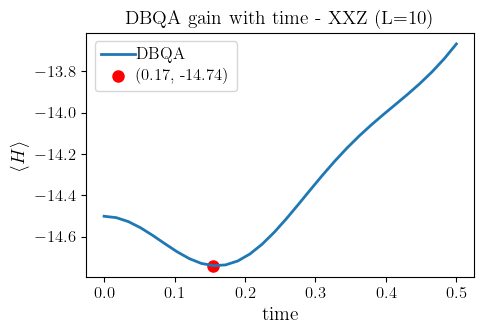

In [119]:
plt.plot(s2_space, expect_ls, label='DBQA')
plt.title(f'DBQA gain with time - XXZ (L={nqubits})')
min_expect = min(expect_ls)
min_idx = expect_ls.index(min_expect)
s2_min = s2_space[min_idx]
plt.scatter(s2_min, min_expect, color='red', label=f'{round(s_min,2), round(min_expect,2)}')
plt.xlabel('time')
plt.ylabel(r'$\langle H\rangle$')
plt.legend()

### 4.2.3 Further optimization

In [57]:
objective2 = lambda D_s: gci_loss_step2(magnetic_field(D_s[:-1], np.abs(D_s[-1])).get_unitary(), H.matrix, u, v1,  np.abs(D_s[-1]))

In [58]:
# setup initial D randomly
s_init = s2_min
D_s = np.append(coef, s_init)
print('Initial loss:', objective2(D_s))

Initial loss: -14.592514028291419


In [59]:
max_iter = 5000
result = minimize(
    objective2,
    D_s,
    method="COBYLA",
    options={"disp": True, "maxiter": max_iter},
    tol=1e-2,
)

print(result.fun)
print(result.x)

-14.72385982880039

[2.61783138 2.50067154 1.87060835 2.48361892 1.8816739  2.49626863
 1.86560379 2.00148203 1.93935627 1.99437035 0.11240225]
   Normal return from subroutine COBYLA

   NFVALS =   98   F =-1.472386E+01    MAXCV = 0.000000E+00
   X = 2.617831E+00   2.500672E+00   1.870608E+00   2.483619E+00   1.881674E+00
       2.496269E+00   1.865604E+00   2.001482E+00   1.939356E+00   1.994370E+00
       1.124023E-01


In [60]:
if result.fun < objective2(D_s):
    D_coef_2 = result.x[:-1]
    s_min_2 = result.x[-1]
    print('Optimised D and s gives better result:', result.fun)
else:
    D_coef_2 = coef
    s_min_2 = s_init
    print('Homogenous D gives better result:', objective2(D_s))
print('s:', s_min_2)
print('D:', D_coef_2)  

Optimised D and s gives better result: -14.72385982880039
s: 0.11240225378852373
D: [2.61783138 2.50067154 1.87060835 2.48361892 1.8816739  2.49626863
 1.86560379 2.00148203 1.93935627 1.99437035]


## 4.3 Emulation

To run this step, we need to first run section 4.1

### 4.3.1 Circuit compilation

In [79]:
# D2 from the previous step (after optimization)
D_coef_2 = [2.61783138, 2.50067154, 1.87060835, 2.48361892, 1.8816739,  2.49626863,
 1.86560379, 2.00148203, 1.93935627, 1.99437035]
t2 = 0.1124
D_s = D_coef_2 + [t2]
D2_circ = magnetic_field(D_coef_2, t2)
print(objective2(D_s))

-14.723861831856338


$$
\begin{align}
U_2 &= UV_1e^{it_2D_2}V_1^\dagger e^{-it_2A_0}V_1e^{-it_2D_2}\\
&=
U
e^{it_1D_1}U^\dagger e^{-it_1H}Ue^{it_2D_2}U^\dagger e^{it_1H}Ue^{-it_1D_1}U^\dagger e^{-it_2H}U e^{it_1D_1} U^\dagger e^{-it_1H}Ue^{-i(t_1D_1+t_2D_2)}
\end{align}
$$

In [83]:
# Compose the circuit
ham_evol = lambda t: XXZ_decomposition(nqubits, t, layer=3, boundary='periodic')
sequence = [i for i in range(nqubits)]
qc_1step = deepcopy(V1)
qc_1step.add_circuit(vqe_circ, sequence)

qc_2step = deepcopy(D2_circ)
qc_2step.add_circuit(V1, sequence)
qc_2step.add_circuit(vqe_circ, sequence)
qc_2step.add_circuit(ham_evol(t2), sequence)
qc_2step.add_circuit(vqe_circ_inverse, sequence)
qc_2step.add_circuit(V1.dagger(), sequence)
qc_2step.add_circuit(D2_circ.dagger(), sequence)
qc_2step.add_circuit(qc_1step, sequence)
print(unitary_expectation(H.matrix, qc_1step.get_unitary()))
print(unitary_expectation(H.matrix, qc_2step.get_unitary()))

-14.503196508205884
-14.720315007534456


In [84]:
print("1-Step circuit depth:", qc_1step.depth())
print("2-Step circuit depth:", qc_2step.depth())
print("1-Step circuit total gate count:", qc_1step.n_gates)
print("2-Step circuit total gate count:", qc_2step.n_gates)
num_cnots_1 = sum(1 for command in qc_1step if command.op.type == OpType.CX)
num_cnots_2 = sum(1 for command in qc_2step if command.op.type == OpType.CX)
print("1-Step circuit CNOT count:", num_cnots_1)
print("2-Step circuit CNOT count:", num_cnots_2)

1-Step circuit depth: 47
2-Step circuit depth: 170
1-Step circuit total gate count: 395
2-Step circuit total gate count: 1430
1-Step circuit CNOT count: 0
2-Step circuit CNOT count: 0


### 4.3.2 Initialize project

In [ ]:
import qnexus as qnx
from quantinuum_demo.quantinuum_utils import *
# connect to nexus account
qnx.client.auth.login()

In [87]:
# connect to nexus project
project_name = "DBQA_native_gates_2steps"
project_ref = qnx.projects.get_or_create(name=project_name)
project_ref.df()

# set this in the context
qnx.context.set_active_project(project_ref)

### 4.3.3 Measurement circuits

In [90]:
# XXZ model (periodic)
nqubits = 10
delta = 0.5
terms = {}
for i in range(nqubits):
    term_x_i = create_qubit_pauli_string(nqubits, {i: Pauli.X, (i+1)%nqubits: Pauli.X}, 1)
    term_y_i = create_qubit_pauli_string(nqubits, {i: Pauli.Y, (i+1)%nqubits: Pauli.Y}, 1)
    term_z_i = create_qubit_pauli_string(nqubits, {i: Pauli.Z, (i+1)%nqubits: Pauli.Z}, delta)
    terms.update(term_x_i)
    terms.update(term_y_i)
    terms.update(term_z_i)
ham_quantinuum = QubitPauliOperator(terms)
terms = [term for term in ham_quantinuum._dict.keys()]
measurement_setup = measurement_reduction(
    terms, strat=PauliPartitionStrat.CommutingSets
)

### 4.3.4 Upload circuits

In [91]:
optimisation_level = 2
# create list of circuits for measurement in different bases
vqe_circuit_ref_list = []
gci_circuit_ref_list = []
for i, mc in enumerate(measurement_setup.measurement_circs):
    c = vqe_circ.copy()
    c.append(mc)
    measurement_vqe_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement vqe circuit {i}",
            )
    # replace with 2 steps GCI circuit
    c = qc_2step.copy()
    c.append(mc)
    measurement_gci_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement gci circuit {i}",
            )
    vqe_circuit_ref_list.append(measurement_vqe_circuit_ref)
    gci_circuit_ref_list.append(measurement_gci_circuit_ref)

# compile vqe measurement circuit list
compiled_vqe_circuit_refs = qnx.compile(
            name=f"compile_job_VQE_{datetime.now()}",
            circuits=vqe_circuit_ref_list,
            optimisation_level=optimisation_level,
            backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
            timeout=None,
        )

# compile gci measurement circuit list
compiled_gci_circuit_refs = qnx.compile(
            name=f"compile_job_GCI_{datetime.now()}",
            circuits=gci_circuit_ref_list,
            optimisation_level=optimisation_level,
            backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
            timeout=None,
        )

### 4.3.4 Noisless execution

In [93]:
from pathlib import Path
import os

In [94]:
# Configuration
nshots = 2000
backend_config = qnx.QuantinuumConfig(device_name="H1-1LE")
optimizer = 'cobyla'
# with noise
# backend_config = qnx.QuantinuumConfig(
#     device_name='H1-Emulator',
#     attempt_batching=True,
# )

runs = 6
for _ in range(runs):
    vqe_job_name = f"execute_job_VQE_{nshots}shots_{datetime.now()}"
    gci_job_name = f"execute_job_GCI_{nshots}shots_{datetime.now()}"
    results_vqe = qnx.start_execute_job(
                name=vqe_job_name,
                circuits=compiled_vqe_circuit_refs,
                n_shots=[nshots]*len(vqe_circuit_ref_list),
                backend_config=backend_config,
            )
    results_gci = qnx.start_execute_job(
                name=gci_job_name,
                circuits=compiled_gci_circuit_refs,
                n_shots=[nshots]*len(gci_circuit_ref_list),
                backend_config=backend_config,
            )
    folder_path = f'results/qnx_job_ref/{optimizer}_{nqubits}q_{nlayer}l_{optimisation_level}ol_XXZ_native_2steps/'
    os.makedirs(folder_path, exist_ok=True)
    qnx.filesystem.save(
        ref=results_vqe,
        path=Path.cwd() / folder_path / vqe_job_name,
        mkdir=True,
    )
    qnx.filesystem.save(
        ref=results_gci,
        path=Path.cwd() /folder_path / gci_job_name,
        mkdir=True,
    )

In [95]:
print(qnx.jobs.status(results_vqe))
print(qnx.jobs.status(results_gci))

JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 2, 10, 5, 25, 33, 987998, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2025, 2, 10, 5, 12, 19, 488087, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 2, 10, 5, 25, 14, 582072, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)
JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 2, 10, 5, 29, 3, 303158, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2025, 2, 10, 5, 12, 20, 95418, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 2, 10, 5, 25, 34, 112814, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)


In [101]:
vqe_results = [job.download_result() for job in qnx.jobs.results(results_vqe)]
gci_results = [job.download_result() for job in qnx.jobs.results(results_gci)]

In [102]:
# print the result from the last run
expval_vqe = compute_expectation_value_from_results(
    vqe_results, measurement_setup, ham_quantinuum
)
print(expval_vqe)
expval_gci = compute_expectation_value_from_results(
    gci_results, measurement_setup, ham_quantinuum
)
print(expval_gci)

-13.5125
-14.735500000000005


### 4.3.5 Noisy execution

In [103]:
# Configuration
nshots = 2000
# with noise
backend_config = qnx.QuantinuumConfig(
    device_name='H1-Emulator',
    attempt_batching=True,
)
runs = 6
for _ in range(runs):
    vqe_job_name = f"execute_job_VQE_{nshots}shots_noise_{datetime.now()}"
    gci_job_name = f"execute_job_GCI_{nshots}shots_noise_{datetime.now()}"
    results_vqe = qnx.start_execute_job(
                name=vqe_job_name,
                circuits=compiled_vqe_circuit_refs,
                n_shots=[nshots]*len(vqe_circuit_ref_list),
                backend_config=backend_config,
            )
    results_gci = qnx.start_execute_job(
                name=gci_job_name,
                circuits=compiled_gci_circuit_refs,
                n_shots=[nshots]*len(gci_circuit_ref_list),
                backend_config=backend_config,
            )
    folder_path = f'results/qnx_job_ref/{optimizer}_{nqubits}q_{nlayer}l_{optimisation_level}ol_XXZ_native_2steps/'
    os.makedirs(folder_path, exist_ok=True)
    qnx.filesystem.save(
        ref=results_vqe,
        path=Path.cwd() / folder_path / vqe_job_name,
        mkdir=True,
    )
    qnx.filesystem.save(
        ref=results_gci,
        path=Path.cwd() /folder_path / gci_job_name,
        mkdir=True,
    )

In [107]:
print(qnx.jobs.status(results_vqe))
print(qnx.jobs.status(results_gci))

JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 2, 10, 7, 4, 9, 404879, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2025, 2, 10, 7, 0, 4, 78559, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 2, 10, 7, 4, 6, 330571, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)
JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 2, 10, 7, 4, 23, 645510, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2025, 2, 10, 7, 0, 4, 989652, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 2, 10, 7, 4, 8, 348745, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)


In [108]:
# results from the last run
vqe_noise_results = [job.download_result() for job in qnx.jobs.results(results_vqe)]
gci_noise_results = [job.download_result() for job in qnx.jobs.results(results_gci)]
expval_vqe_noise = compute_expectation_value_from_results(
    vqe_noise_results, measurement_setup, ham_quantinuum
)
print(expval_vqe_noise)
expval_gci_noise = compute_expectation_value_from_results(
    gci_noise_results, measurement_setup, ham_quantinuum
)
print(expval_gci_noise)

-13.450499999999998
-14.174500000000005


### 4.3.6 Report

In [109]:
optimizer = 'cobyla'
optimisation_level = 2
folder_path = Path(f'results/qnx_job_ref/{optimizer}_{nqubits}q_{nlayer}l_{optimisation_level}ol_XXZ_native_2steps/')


# Initialize lists
gci_path_list = []
gci_noise_path_list = []
vqe_path_list = []
vqe_noise_path_list = []

for file in folder_path.iterdir():
    if file.is_file():
        name = file.stem  # Use .stem to exclude the file extension
        if name.startswith('execute_job_GCI_') and 'noise' not in name:
            gci_path_list.append(file.resolve())
        elif name.startswith('execute_job_GCI_') and 'noise' in name:
            gci_noise_path_list.append(file.resolve())
        elif name.startswith('execute_job_VQE_') and 'noise' not in name:
            vqe_path_list.append(file.resolve())
        elif name.startswith('execute_job_VQE_') and 'noise' in name:
            vqe_noise_path_list.append(file.resolve())

# verify list length
print('VQE noiseless job counts:', len(vqe_path_list))
print('VQE noise job counts:', len(vqe_noise_path_list))
print('GCI noiseless job counts:', len(gci_path_list))
print('GCI noise job counts:', len(gci_noise_path_list))

VQE noiseless job counts: 6
VQE noise job counts: 6
GCI noiseless job counts: 6
GCI noise job counts: 6


In [110]:
# load the job references
vqe_job_refs = job_ref_from_path_list(vqe_path_list)
vqe_noise_job_refs = job_ref_from_path_list(vqe_noise_path_list)
gci_job_refs = job_ref_from_path_list(gci_path_list)
gci_noise_job_refs = job_ref_from_path_list(gci_noise_path_list)

In [111]:
# load job results from job references
def load_job_results(job_refs):
    job_results = []
    for job_ref in job_refs:
        job_result = [job.download_result() for job in qnx.jobs.results(job_ref)]
        job_results.append(job_result)
    return job_results

vqe_job_results = load_job_results(vqe_job_refs)
vqe_noise_job_results = load_job_results(vqe_noise_job_refs)
gci_job_results = load_job_results(gci_job_refs)
gci_noise_job_results = load_job_results(gci_noise_job_refs)

In [112]:
vqe_expvals = [compute_expectation_value_from_results(
    job_result, measurement_setup, ham_quantinuum
) for job_result in vqe_job_results]

vqe_noise_expvals = [compute_expectation_value_from_results(
    job_result, measurement_setup, ham_quantinuum
) for job_result in vqe_noise_job_results]

gci_expvals = [compute_expectation_value_from_results(
    job_result, measurement_setup, ham_quantinuum
) for job_result in gci_job_results]

gci_noise_expvals = [compute_expectation_value_from_results(
    job_result, measurement_setup, ham_quantinuum
) for job_result in gci_noise_job_results]

In [118]:
vqe_energy = unitary_expectation(H.matrix, u)
dbqa_energy = objective2(D_s)

In [120]:
report_native_2steps = report(H, nshots, vqe_energy, dbqa_energy, vqe_expvals, gci_expvals, vqe_noise_expvals, gci_noise_expvals)

In [121]:
report_table(report_native_2steps)

,Analytical,Emulator,Emulator with Noise
VQE energy,-13.6867,-13.7203 ± 0.1804,-13.4485 ± 0.0780
GCI energy,-14.7239,-14.7024 ± 0.1133,-14.0743 ± 0.0892
Difference to target (VQE),1.5894,1.5558 ± 0.1804,1.8276 ± 0.0780
Difference to target (GCI),0.5523,0.5737 ± 0.1133,1.2018 ± 0.0892
Percentage difference to target (VQE),10.40%,10.18% ± 1.18%,11.96% ± 0.51%
Percentage difference to target (GCI),3.62%,3.76% ± 0.74%,7.87% ± 0.58%
Fidelity witness (VQE),-0.4613,-0.4304 ± 0.1659,-0.6803 ± 0.0717
Fidelity witness (GCI),0.4922,0.4725 ± 0.1659,-0.1049 ± 0.0820


# 5. Ising model as D

To cover more interactions among the qubits, we can use the Ising model instead of a magnetic field
for the diagonal operator $\hat D$.

$$
\hat D = \sum_i \alpha_i Z_i + \sum_{\{i,j\}}\beta_{i,j}Z_iZ_j
$$

## 5.1 Nearest neighbor

For our application, we may consider the nearest-neighbor Ising model,
where the second term is restricted to
$$
\sum_i\beta_iZ_iZ_{i+1}
    $$

In [137]:
def nearest_neighbor_ising_model(nqubits, coefs, t):
    # check coef length
    if len(coefs) != 2*nqubits:
        raise ValueError(f"Number of params {len(coefs)} does not match the expected {nqubits}.")
    
    # implments e^{-itD}
    qc = Circuit(nqubits)
    for idx, coef in enumerate(coefs):
        theta = 2 * t * coef / np.pi
        if idx < nqubits:
            qc.Rz(theta, idx)
        else:
            qc.ZZPhase(theta, idx-nqubits, (idx-nqubits+1)%nqubits)
    return qc    

# test 3 qubits
coefs = [1,1,1,2,2,2]
ising = nearest_neighbor_ising_model(3, coefs, 1).get_unitary()
ising_test = hamiltonians.SymbolicHamiltonian(sum([coefs[x]*Z(x) for x in range(3)]+[coefs[x+3]*Z(x)*Z((x+1)%3) for x in range(3)])).circuit(1).unitary()
print(np.linalg.norm(ising - ising_test))

7.092622233518052e-16


In [131]:
# define a loss function
def gci_loss_step1(d1, h, u, s):
    """Return the analytical loss from a GCI step

    Args:
        d1 (np.array): magnetic field circuit matrix for GCI step 2
        h (np.array): the Input Hamiltonian matrix
        u (np.array): the VQE unitary
        v1 (np.array): the first GCI circuit unitary
        s2 (float): the GCI rotation duration for the second step
    """
    d1_dag = d1.conjugate()
    h_evol = scipy.linalg.expm(-1j*s*h)
    U1 = u @ d1_dag @ u_dag @ h_evol @ u @ d1
    return unitary_expectation(h, U1)

In [138]:
# loss curve step 1
seed = 10
np.random.seed(seed)
coef = np.random.uniform(0, 1, 2*nqubits)
D_circ_qibo = hamiltonians.SymbolicHamiltonian(sum([coef[x]*Z(x) for x in range(nqubits)]+[coef[x+nqubits]*Z(x)*Z((x+1)%nqubits) for x in range(nqubits)]))
s_space = np.linspace(0, 0.5, 30)
expect_ls = []
for s in s_space:
    d = D_circ_qibo.circuit(s).unitary()
    loss = gci_loss_step1(d, H.matrix, u, s)
    expect_ls.append(loss)

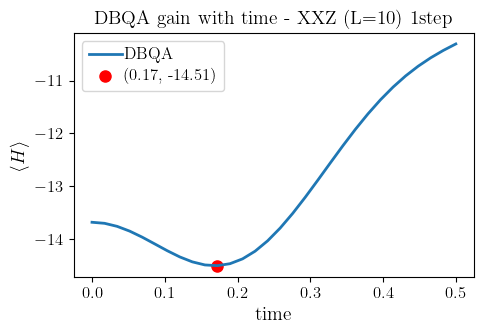

In [139]:
plt.plot(s_space, expect_ls, label='DBQA')
plt.title(f'DBQA gain with time - XXZ (L={nqubits}) 1step')
min_expect = min(expect_ls)
min_idx = expect_ls.index(min_expect)
s_min = s_space[min_idx]
plt.scatter(s_min, min_expect, color='red', label=f'{round(s_min,2), round(min_expect,2)}')
plt.xlabel('time')
plt.ylabel(r'$\langle H\rangle$')
plt.legend()

In [140]:
objective1_nn = lambda D_s: gci_loss_step1(nearest_neighbor_ising_model(nqubits, D_s[:-1], np.abs(D_s[-1])).get_unitary(), H.matrix, u, np.abs(D_s[-1]))

In [147]:
max_iter = 5000
D_s = np.append(coef, s_min)
result = minimize(
    objective1_nn,
    D_s,
    method="COBYLA",
    options={"disp": True, "maxiter": max_iter},
    tol=1e-2,
)

print(result.fun)
print(result.x)

-14.559717462850763

[1.6487502  0.07723971 0.4251229  0.70830856 0.67624063 0.40414917
 0.37706987 0.7250455  0.3367117  0.28579502 0.71476732 0.88307867
 0.20631289 0.28915928 0.64622619 0.35069305 0.70871442 0.49246997
 0.82405993 0.65284566 0.15239078]
   Normal return from subroutine COBYLA

   NFVALS =  588   F =-1.455972E+01    MAXCV = 0.000000E+00
   X = 1.648750E+00   7.723971E-02   4.251229E-01   7.083086E-01   6.762406E-01
       4.041492E-01   3.770699E-01   7.250455E-01   3.367117E-01   2.857950E-01
       7.147673E-01   8.830787E-01   2.063129E-01   2.891593E-01   6.462262E-01
       3.506931E-01   7.087144E-01   4.924700E-01   8.240599E-01   6.528457E-01
       1.523908E-01


In [15]:
# loss curve
# Find optimal starting s
seed = 10
np.random.seed(seed)
coef = np.random.uniform(0, 1, 2*nqubits)
# coef = [1] * 2* nqubits
D2_circ_qibo = hamiltonians.SymbolicHamiltonian(sum([coef[x]*Z(x) for x in range(nqubits)]+[coef[x+nqubits]*Z(x)*Z((x+1)%nqubits) for x in range(nqubits)]))
s2_space = np.linspace(0, 0.5, 30)
expect_ls = []
for s2 in s2_space:
    d2 = D2_circ_qibo.circuit(s2).unitary()
    gci_loss_step2(d2, H.matrix, u, v1, s2)
    expect_ls.append(gci_loss_step2(d2, H.matrix, u, v1, s2))

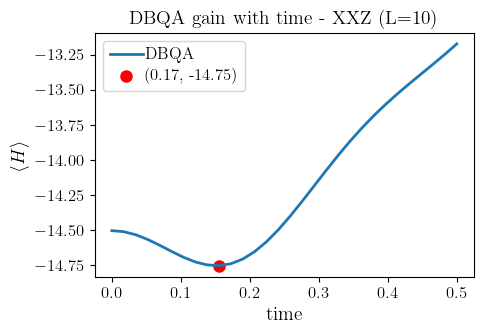

In [16]:
plt.plot(s2_space, expect_ls, label='DBQA')
plt.title(f'DBQA gain with time - XXZ (L={nqubits}) 2steps')
min_expect = min(expect_ls)
min_idx = expect_ls.index(min_expect)
s2_min = s2_space[min_idx]
plt.scatter(s2_min, min_expect, color='red', label=f'{round(s_min,2), round(min_expect,2)}')
plt.xlabel('time')
plt.ylabel(r'$\langle H\rangle$')
plt.legend()

In [17]:
objective2_nn = lambda D_s: gci_loss_step2(nearest_neighbor_ising_model(nqubits, D_s[:-1], np.abs(D_s[-1])).get_unitary(), H.matrix, u, v1,  np.abs(D_s[-1]))

In [18]:
# setup initial D randomly
s_init = s2_min
D_s = np.append(coef, s_init)
print('Initial loss:', objective2_nn(D_s))

Initial loss: -14.75274977899646


In [19]:
max_iter = 5000
result = minimize(
    objective2_nn,
    D_s,
    method="COBYLA",
    options={"disp": True, "maxiter": max_iter},
    tol=1e-2,
)

print(result.fun)
print(result.x)

-14.754962259931691
   Normal return from subroutine COBYLA


[0.43690427 0.21293661 0.76108947 0.6386566  0.70464484 0.17947505
 0.39883887 0.63902607 0.32623089 0.22475982 0.59152443 0.83523374
 0.18460624 0.65577683 0.68496285 0.74353235 0.45699468 0.48097837
 1.05877869 0.76228969 0.16204331]
   NFVALS =  406   F =-1.475496E+01    MAXCV = 0.000000E+00
   X = 4.369043E-01   2.129366E-01   7.610895E-01   6.386566E-01   7.046448E-01
       1.794750E-01   3.988389E-01   6.390261E-01   3.262309E-01   2.247598E-01
       5.915244E-01   8.352337E-01   1.846062E-01   6.557768E-01   6.849629E-01
       7.435324E-01   4.569947E-01   4.809784E-01   1.058779E+00   7.622897E-01
       1.620433E-01


## 5.2 All-to-all Ising

In [21]:
def all_to_all_ising_model(nqubits, coefs, t):
    # Check that coefficient length
    expected_length = nqubits * (nqubits + 1) // 2
    if len(coefs) != expected_length:
        raise ValueError(
            f"Number of params {len(coefs)} does not match expected number "
            f"{expected_length} for {nqubits} qubits."
        )
    
    qc = Circuit(nqubits)
    
    # apply the local (single-qubit) Z rotations
    for i in range(nqubits):
        theta = 2 * t * coefs[i] / np.pi
        qc.Rz(theta, i)
    
    # apply ZZ interactions between every distinct pair i<j
    index = nqubits  # starting index for two-qubit coupling terms
    for i in range(nqubits):
        for j in range(i+1, nqubits):
            theta = 2 * t * coefs[index] / np.pi
            qc.ZZPhase(theta, i, j)
            index += 1
    return qc

# Example test for 3 qubits:
coefs = [1, 1, 1, 2, 2, 2]  # For 3 qubits, 3 local terms and 3 coupling terms.
ising_all_to_all = all_to_all_ising_model(3, coefs, 1).get_unitary()
ising_test = hamiltonians.SymbolicHamiltonian(sum([coefs[x]*Z(x) for x in range(3)]+[coefs[x+3]*Z(x)*Z((x+1)%3) for x in range(3)])).circuit(1).unitary()
print(np.linalg.norm(ising_all_to_all - ising_test))


6.916653802134305e-16


In [24]:
expected_coef_length = nqubits * (nqubits + 1) // 2
seed = 10
np.random.seed(seed)
coef = np.random.uniform(0, 1, expected_coef_length)
s2_space = np.linspace(0, 0.5, 30)
expect_ls = []
for s2 in s2_space:
    d2 = all_to_all_ising_model(nqubits, coef, s2).get_unitary()
    gci_loss_step2(d2, H.matrix, u, v1, s2)
    expect_ls.append(gci_loss_step2(d2, H.matrix, u, v1, s2))

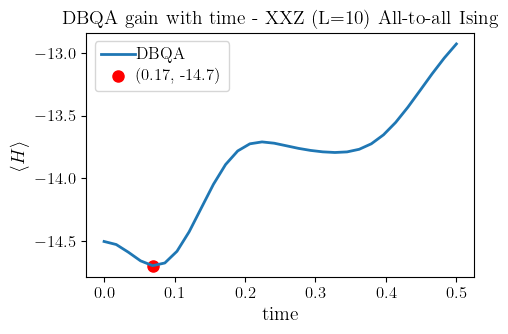

In [25]:
plt.plot(s2_space, expect_ls, label='DBQA')
plt.title(f'DBQA gain with time - XXZ (L={nqubits}) All-to-all Ising')
min_expect = min(expect_ls)
min_idx = expect_ls.index(min_expect)
s2_min = s2_space[min_idx]
plt.scatter(s2_min, min_expect, color='red', label=f'{round(s_min,2), round(min_expect,2)}')
plt.xlabel('time')
plt.ylabel(r'$\langle H\rangle$')
plt.legend()

# 6. Higher-order GCI

The double-bracket rotation unitary is given by
$$
U_k = e^{-s_k[D_k, A_k]}
$$
and the group commutator unitary is given by
$$
V^{(GC)} = e^{i\sqrt{s_k}A_k}e^{i\sqrt{s_k}D_k}e^{-i\sqrt{s_k}A_k}e^{-i\sqrt{s_k}D_k}=e^{-s_k[D_k, A_k]} + O(s_k^{3/2})
$$

In the previous sections, we used the equivalent reduced group commutator formula where
$$
V^{(RGC)} = e^{i\sqrt{s_k}D_k}e^{-i\sqrt{s_k}A_k}e^{-i\sqrt{s_k}D_k},
$$
this is valid considering the notation
$$
A_{k+1} = V_k^\dagger A_k V_k.
$$

It is also possible to use a more general group commutator formula to obtain a better approximation following [this reference](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.013191),

from which we have
$$
V^{(HOPF)} = e^{i\phi\sqrt{s_k}A_k}e^{i\phi\sqrt{s_k}D_k}e^{-i\sqrt{s_k}A_k}
            e^{-i(\phi+1)\sqrt{s_k}D_k}e^{i(1-\phi)\sqrt{s_k}A_k}e^{i\phi\sqrt{s_k}D_k},
$$
where $\phi=\frac{1}{2}(\sqrt 5 -1)$.
This gives a higher-order approximation by canceling the first and third-order terms, thus retaining the leading second-order term needed for the approximation of the double-bracket rotation unitary. 
We will refer to it as the
3rd order group commutator to stress the cancellation of the third order expansion term.

Finally, we use again canceling and consider a reduced version of the above group commutator

$$
V^{(RHOPF)} = e^{i\phi\sqrt{s_k}D_k}e^{-i\sqrt{s_k}A_k}
            e^{-i(\phi+1)\sqrt{s_k}D_k}e^{i(1-\phi)\sqrt{s_k}A_k}e^{i\phi\sqrt{s_k}D_k},
$$
more explicitly,
$$
V_1^{(RHOPF)} = e^{i\phi t D}U^\dagger e^{-itH} U
            e^{-i(\phi+1)t D}U^\dagger e^{i(1-\phi)tH} U e^{i\phi t D},
$$
where $t = \sqrt{s}$.

Then we have $A_1 = {V_1^{(RHOPF)}}^\dagger U^\dagger H U V_1^{(RHOPF)}$, since
$$
\langle 0|A_1|0\rangle =\langle \psi_1|H_0|\psi\rangle,
$$
where $|\psi\rangle = U* V_1^{(RHOPF)}|0\rangle$.
Our composed reduced 3rd order GCI circuit (step 1) should follow
$$
U_1^{(RHOPF)} = U \cdot V_1^{(RHOPF)}=Ue^{i\phi t D}U^\dagger e^{-itH} U
            e^{-i(\phi+1)t D}U^\dagger e^{i(1-\phi)tH} U e^{i\phi t D}.
$$

## 6.1 Unitary components

In [27]:
# Create Hamiltonian
nqubits = 10
H = hamiltonians.models.XXZ(nqubits=nqubits, delta=0.5, dense=False)

In [28]:
# Load the VQE circuit
optimizer = 'cobyla'
nqubits = nqubits
nlayer = 1
folder_path = f'results/circuit_qasm/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
vqe_circ_file = folder_path + 'vqe_circ.qasm'
vqe_circ = pytket.qasm.circuit_from_qasm(vqe_circ_file)
vqe_circ_inverse = vqe_circ.dagger()
u = vqe_circ.get_unitary()
u_dag = u.T.conjugate()

In [42]:
# D circuit (magnetic)
coef = [1] * nqubits
D_sym_ham = hamiltonians.SymbolicHamiltonian(sum([coef[x]*Z(x) for x in range(nqubits)]))
t = 0.172

In [48]:
phi = (np.sqrt(5)-1)/2
v1_rhopf = D_sym_ham.circuit(-phi*t).unitary()@u_dag@H.circuit(t).unitary()@u@D_sym_ham.circuit((phi+1)*t).unitary()@u_dag@H.circuit((phi-1)*t).unitary()@u@D_sym_ham.circuit(-phi*t).unitary()
u_rhopf = u @ v1_rhopf
print(unitary_expectation(H.matrix, u_rhopf))

-14.215158313758218


In [47]:
unitary_expectation(H.matrix, u)

-13.686694061712272

In [54]:
t_space = np.linspace(0.1, 0.3, 10)
exp_ls = []
for t in t_space:
    v1_rhopf = D_sym_ham.circuit(-phi*t).unitary()@u_dag@H.circuit(t).unitary()@u@D_sym_ham.circuit((phi+1)*t).unitary()@u_dag@H.circuit((phi-1)*t).unitary()@u@D_sym_ham.circuit(-phi*t).unitary()
    u_rhopf = u @ v1_rhopf
    exp_ls.append(unitary_expectation(H.matrix, u_rhopf))

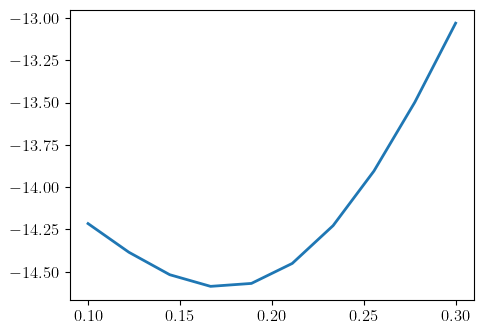

In [55]:
plt.plot(t_space, exp_ls)

In [56]:
print(min(exp_ls))

-14.586313191717384
